# Visual Inspection of Motorcycle Connecting Rods
## Task 1
The objective of this project is the visual inspection of motorcycle connecting rods. The system should be able to analyze the dimensions of two different types of connecting rods to allow a vision-guided  robot  to pick and sort rods based on their type and dimensions. The two rod types are characterized by a different number of holes: Type A rods have one hole whilst Type B rods have two holes.

In this file I will only consider the requirements of the first task. For each connecting rod, the system must provide the following information:
1.  Type of rod (A or B)
2.  Position and orientation (modulo $\pi$)
3.  Length (L), Width (W), Width at the barycenter (WB)
4.  For each hole, position of the centre and diameter size


### Import

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math

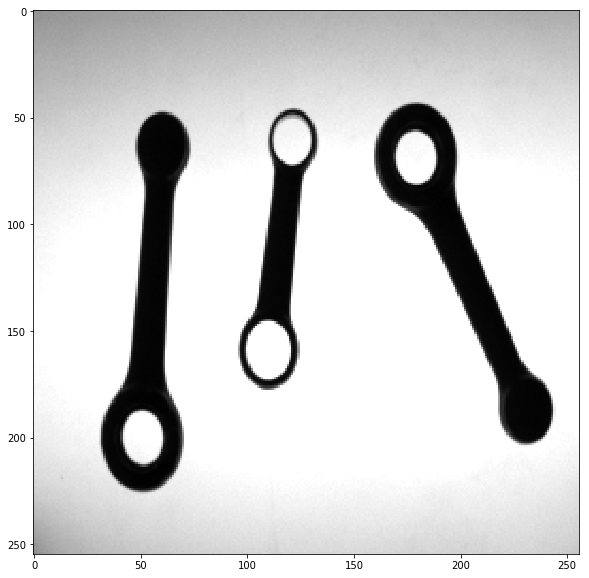

In [2]:
# Load images
img = cv2.imread("imgs_1/TESI00.BMP", cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(15,10))
plt.imshow(img, cmap="gray")
plt.show()

## Binarize images
To binarize the images it was used the Otsu's algorithm, as the lighting condition are not guaranteed to be constant across the different images.

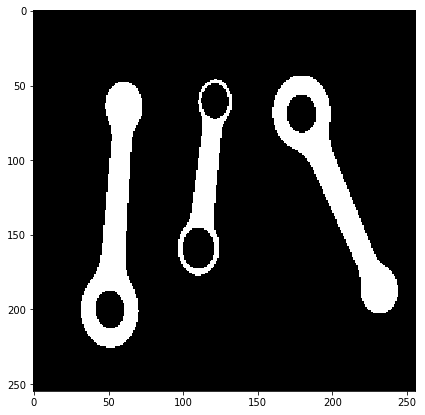

Otsu Threshold: 127.0


In [3]:
th_value, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)

# img_bin = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#                                 cv2.THRESH_BINARY, 71, 20)

# Invert binary image: white foreground, black background
img_bin = 255-img_bin

plt.figure(figsize=(7,7))
plt.imshow(img_bin, cmap="gray")
plt.show()

print("Otsu Threshold: {}".format(th_value))

## Contours
To find the countours I simply used the method provided by OpenCV, as it also provides the hierarchy of the contours, which will be used to determine the type of rod.

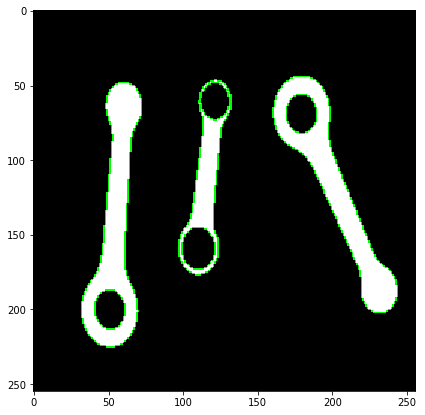

Contour hierarchy: [Next, Previous, First_Child, Parent]
[[[ 2 -1  1 -1]
  [-1 -1 -1  0]
  [ 5  0  3 -1]
  [ 4 -1 -1  2]
  [-1  3 -1  2]
  [-1  2  6 -1]
  [-1 -1 -1  5]]]


In [4]:
img_cont = np.stack([img_bin,img_bin,img_bin], axis=-1)   #3 channel image to draw colored contours
cont, hierarchy = cv2.findContours(image=img_bin, mode=cv2.RETR_CCOMP, method=cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img_cont, cont, -1, (0,255,0), 1)

plt.figure(figsize=(7,7))
plt.imshow(img_cont)
plt.show()

print("Contour hierarchy: [Next, Previous, First_Child, Parent]")
print(hierarchy)


## Type: A-B
For each contour detected, OpenCV provides the "child" and "parent" contours. Using this information I determined the type of rod by counting the number of nested contours: one hole for type A, two holes for type B. This step also allowed to discriminate some distractors: blob with none or more than two holes are not to be considered.

In [5]:
rod_type = []
ext_cont = []
holes_cont = []

for idx, c in enumerate(hierarchy[0]):
    if c[3] == -1:  # if it has no parent, it is external
        
        if c[2] == -1:  # a rod must have at least one hole
            continue    

        hole_1 = hierarchy[0][c[2]]

        if hole_1[0] == -1: # only one hole: type A
            rod_type.append('A')
            ext_cont.append(cont[idx][:,0])
            holes_cont.append([cont[c[2]][:,0]])
            continue

        hole_2 = hierarchy[0][hole_1[0]]

        if hole_2[0] == -1: # two holes: type B
            rod_type.append('B')
            ext_cont.append(cont[idx][:,0])
            holes_cont.append([cont[c[2]][:,0], cont[hole_1[0]][:,0]])

        continue    # a rod cannot have more than two holes

print("Rod Types: ", rod_type)

Rod Types:  ['A', 'B', 'A']


## Position and Orientation
The orientation of the blob was determined by analyzing the moments of the contour. Then, given the major and minor axis it was possible to determine the Minimum Enclosing Rectangle.

In [6]:
def computeMinimumEnclosingRectangle(cont):
    # Moments of the blob
    moments = cv2.moments(cont)
    m00 = moments['m00']        # OpenCV compute moments as Mji = sum(x^j*y^i)
    m11 = moments['mu11']       # i,j inverted compared to the slide
    m10 = moments['m10']
    m01 = moments['m01']
    m20 = moments['mu20']
    m02 = moments['mu02']

    # Barycenter
    bx, by = int(m10/m00), int(m01/m00)

    # Orientation
    theta = -0.5*math.atan(2*m11/(m20-m02))
    theta = np.where(m20-m02 > 0, theta, theta+math.pi/2)   # the previous formula is a minimum(major axis)
                                                            # only if the denominator is > 0 ???
    theta = np.where(theta < 0, theta+math.pi, theta)   # orientation must be in the interval [0,pi]

    # Major and Minor axis
    alpha, beta = -math.sin(theta), math.cos(theta)

    a_MA = alpha
    b_MA = -beta
    c_MA = beta*by - alpha*bx
    MA = (a_MA, b_MA, c_MA)

    a_MI = beta
    b_MI = alpha
    c_MI = -beta*bx - alpha*by
    MI = (a_MI, b_MI, c_MI)

    # Compute the four points laying at maximum distance on opposite sides of the two axes
    dMAmin = float("inf")
    dMAmax = -float("inf")
    dMImin = float("inf")
    dMImax = -float("inf")

    i1, j1 = 0, 0   # Major axis, positive side
    i2, j2 = 0, 0   # Major axis, negative side
    i3, j3 = 0, 0   # Minor axis, positive side
    i4, j4 = 0, 0   # Minor axis, negative side

    normMA = math.sqrt(a_MA*a_MA + b_MA*b_MA)
    normMI = math.sqrt(a_MI*a_MI + b_MI*b_MI)

    for j, i in cont:
        dMA = (a_MA*j+b_MA*i+c_MA) / normMA
        dMI = (a_MI*j+b_MI*i+c_MI) / normMI

        if dMA < dMAmin:
            dMAmin = dMA
            i1, j1 = i, j

        if dMA > dMAmax:
            dMAmax = dMA
            i2, j2 = i, j

        if dMI < dMImin:
            dMImin = dMI
            i3, j3 = i, j

        if dMI > dMImax:
            dMImax = dMI
            i4, j4 = i, j

    # Offsets of the lines parallel to the major and minor axis
    cl1 = -a_MA*j1 - b_MA*i1
    cl2 = -a_MA*j2 - b_MA*i2
    cw1 = -a_MI*j3 - b_MI*i3
    cw2 = -a_MI*j4 - b_MI*i4

    # Vertex of the Minimum Enclosing Rectangle
    v1 = [(b_MA*cw1 - b_MI*cl1)/(a_MA*b_MI-b_MA*a_MI), (a_MI*cl1 - a_MA*cw1)/(a_MA*b_MI-b_MA*a_MI)]
    v2 = [(b_MA*cw2 - b_MI*cl1)/(a_MA*b_MI-b_MA*a_MI), (a_MI*cl1 - a_MA*cw2)/(a_MA*b_MI-b_MA*a_MI)]
    v3 = [(b_MA*cw1 - b_MI*cl2)/(a_MA*b_MI-b_MA*a_MI), (a_MI*cl2 - a_MA*cw1)/(a_MA*b_MI-b_MA*a_MI)]
    v4 = [(b_MA*cw2 - b_MI*cl2)/(a_MA*b_MI-b_MA*a_MI), (a_MI*cl2 - a_MA*cw2)/(a_MA*b_MI-b_MA*a_MI)]
    vrtx = np.array([v1,v2,v4,v3], np.int32)

    return vrtx, (bx,by), MA, MI, theta

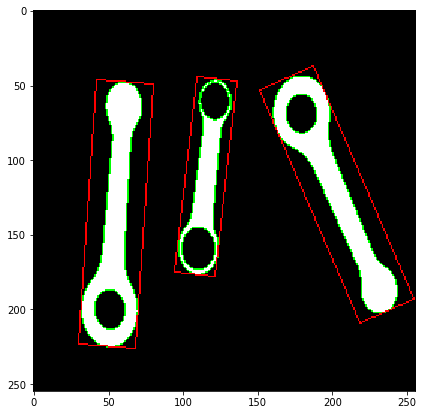

Orientations:  [array(1.50150249), array(1.45796094), array(1.97712901)]
Barycenters:  [(54, 148), (115, 115), (198, 113)]


In [7]:
img_MER = np.copy(img_cont)
MER_vrtx = []
barycenters = []
major_axis = []
minor_axis = []
orientation = []

for c in ext_cont:
    box, B, MA, MI, theta = computeMinimumEnclosingRectangle(c)
    cv2.polylines(img_MER, [box], True, (255,0,0))

    MER_vrtx.append(box)
    barycenters.append(B)
    major_axis.append(MA)
    minor_axis.append(MI)
    orientation.append(theta)

plt.figure(figsize=(7,7))
plt.imshow(img_MER)
plt.show()

print("Orientations: ", orientation)
print("Barycenters: ", barycenters)

## Length, Width, Width at the barycenter
Given the MER, the computation of the length and width is trivial. To determine the width at the barycenter the first approach I tried was to search for the intersection between the minor axis and the contour. The contour provided by OpenCV cannot be approximated (cv2.CHAIN_APPROX_SIMPLE), otherwise it is sparse (as can be seen in the code below).

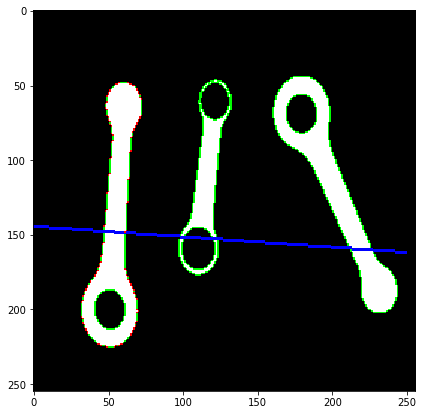

In [8]:
temp = np.copy(img_cont)

a, b, c = minor_axis[0]
for j in range(0,250):
    for i in range(0,250):
        if int(a*j+b*i+c)==0:
            temp[i,j] = [0,0,255]

for x,y in ext_cont[0]:
    temp[y,x] = [255,0,0]

plt.figure(figsize=(7,7))
plt.imshow(temp)
plt.show()

1° rod:
 intersection: 
   * -1 -1
   * 61 148
 width: 38.12
 length: 181.87
 width at B: 161.38
2° rod:
 intersection: 
   * 108 114
   * 122 116
 width: 27.17
 length: 134.54
 width at B: 14.14
3° rod:
 intersection: 
   * 192 116
   * 205 109
 width: 39.40
 length: 173.81
 width at B: 14.76


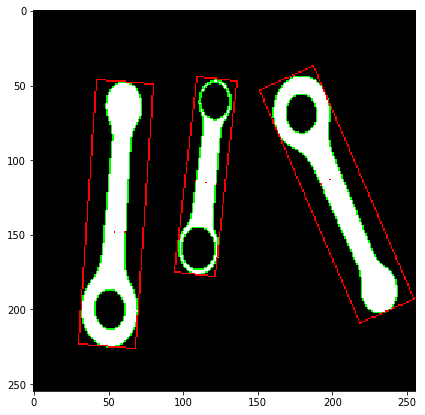

In [9]:
temp = np.copy(img_MER)

def distance(A,B):
    return math.sqrt((A[0]-B[0])**2+(A[1]-B[1])**2)

def barycenterWidth(cont, MA, MI):
    x1, x2 = -1, -1
    y1, y2 = -1, -1
    a_ma, b_ma, c_ma = MA
    a_mi, b_mi, c_mi = MI

    for p in cont:
        if int(p[0]*a_mi + p[1]*b_mi + c_mi) == 0 and p[0]*a_ma + p[1]*b_ma + c_ma > 0:
            x1, y1 = p[0], p[1]
            continue

        if int(p[0]*a_mi + p[1]*b_mi + c_mi) == 0 and p[0]*a_ma + p[1]*b_ma + c_ma < 0:
            x2, y2 = p[0], p[1]
            continue

    temp[y1,x1] = [255,0,0]
    temp[y2,x2] = [255,0,0]
    print(" intersection: ")
    print("   *",x1,y1)
    print("   *",x2,y2)
    return distance((x1,y1),(x2,y2))

for i, (cont, vrtx, MA, MI) in enumerate(zip(ext_cont, MER_vrtx, major_axis, minor_axis)):
    print("{}° rod:".format(i+1))

    W = distance(vrtx[0], vrtx[3])
    L = distance(vrtx[0], vrtx[2])
    Wb = barycenterWidth(cont, MA, MI)

    print(" width: {:.2f}".format(W))
    print(" length: {:.2f}".format(L))
    print(" width at B: {:.2f}".format(Wb))

for b in barycenters:
    temp[b[1],b[0]] = [255,0,0]

plt.figure(figsize=(7,7))
plt.imshow(temp)
plt.show()

In the end, I've extracted the ROI of the oriented blob. In this way, the length and width are provided by the dimension of the ROI, and the width at the barycenter can be easily found by looking for intensities changes in the row of the barycenter.

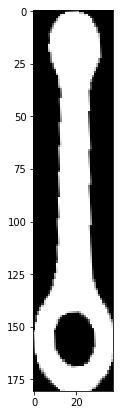

1° rod:
 width: 38.12
 length: 181.87
 width at B: 17.00


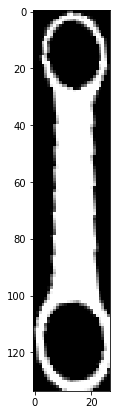

2° rod:
 width: 27.17
 length: 134.54
 width at B: 16.00


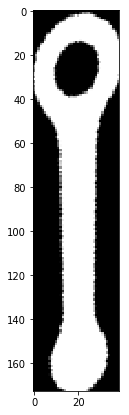

3° rod:
 width: 39.40
 length: 173.81
 width at B: 17.00


In [10]:
def distance(A,B):
    return math.sqrt((A[0]-B[0])**2+(A[1]-B[1])**2)

def getRotatedROI(img, vrtx, W, L):
    dst = np.float32([[0,0], [W,0], [0,L], [W,L]])
    src = np.float32([vrtx[2], vrtx[1], vrtx[3], vrtx[0]])

    transform_matrix = cv2.getPerspectiveTransform(src,dst)
    roi = cv2.warpPerspective(img, transform_matrix, (W,L))
    return roi, transform_matrix

def computeBarycenterWidth(roi, B):
    y = int(B[0][0][1])
    x1, x2 = 0, 0
    previous_pixel = 0
    current_pixel = 0
    for i in range(1, roi.shape[1]):
        previous_pixel = current_pixel
        current_pixel = roi[y, i]
        if previous_pixel == 0 and current_pixel > 0:
            x1 = i
        if previous_pixel > 0 and current_pixel == 0:
            x2 = i
    
    return x2-x1

for i, (cont, vrtx, B) in enumerate(zip(ext_cont, MER_vrtx, barycenters)):
    W = distance(vrtx[0], vrtx[3])
    L = distance(vrtx[0], vrtx[2])
    roi, transform_matrix = getRotatedROI(img_bin, vrtx, int(W), int(L))
    Wb = computeBarycenterWidth(roi, cv2.perspectiveTransform(np.float32([[B]]), transform_matrix))
    plt.figure(figsize=(7,7))
    plt.imshow(roi, cmap="gray")
    plt.show()

    print("{}° rod:".format(i+1))
    print(" width: {:.2f}".format(W))
    print(" length: {:.2f}".format(L))
    print(" width at B: {:.2f}".format(Wb))

## Position of holes
To determine the position of the holes, I've used the OpenCV function `fitEllipse`, which return the position of the barycenters and the length of the axis for a given contour. The diameter was taken as the mean between the length of the major and minor axis.

1° rod:
	1° hole: B=(51.0, 199.9),	d=23.4
2° rod:
	1° hole: B=(109.9, 158.9),	d=25.5
	2° hole: B=(121.1, 60.3),	d=22.0
3° rod:
	1° hole: B=(179.1, 68.8),	d=23.5


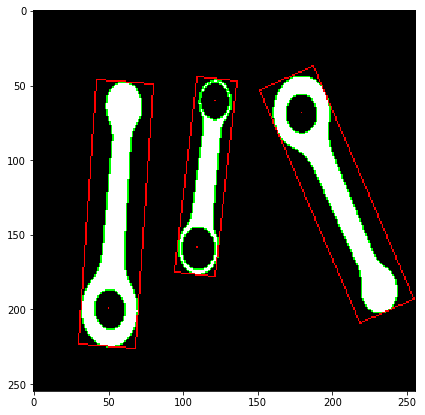

In [11]:
temp = np.copy(img_MER)

for i_r, rod in enumerate(holes_cont):    #for each rod
    print("{}° rod:".format(i_r+1))

    for i_h, hole in enumerate(rod):        #for each hole inside a rod
        ellipse = cv2.fitEllipse(hole)
        (bx,by), (d1,d2), _ = ellipse
        d = (d1+d2) / 2
        print("\t{}° hole: B=({:.1f}, {:.1f}),\td={:.1f}".format(i_h+1, bx, by, d))
        temp[int(by),int(bx)] = [255,0,0]

plt.figure(figsize=(7,7))
plt.imshow(temp)
plt.show()